<hr style="margin-bottom: 50px;">
<center>
    <h1 style="margin-top: 0; margin-bottom: 0;">
        <b><u>Modélisation : Elastic-SARIMAX</u></b>
    </h1>
</center>
<hr style="margin-top: 50px;">

# <b>1. Configuration du notebook

In [1]:
# Imports des modules du projet
import config, src

# Imports classiques
import pandas as pd

# Imports de scikit-learn
from sklearn.linear_model import ElasticNet

# Imports de statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Imports pour la visualisation
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [18]:
# Configuration d'un template par défaut pour la visualisation 
pio.templates['custom'] = pio.templates['plotly_white']
pio.templates['custom'].layout.colorway = px.colors.qualitative.Prism

pio.templates.default = 'custom'

---
# <b>2. Chargement et préparation des données</b>

In [3]:
# Chargement des données prétraitées
data = src.load_data(config.PROCESSED_DATA_FILE)

# Conversion des données au format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Utilisation des dates comme index
data.set_index('Date', inplace=True)

# Ajout de la fréquence des données
data = data.asfreq('10min')

Données chargées avec succès.


In [4]:
# Ajout d'un intercept
data['intercept'] = 1

# Variables explicatives
features = data.columns.drop('Energy')

# Données explicatives
X = data[features]

# Données cibles
y = data['Energy']

---
# <b>3. Définition du modèle</b>

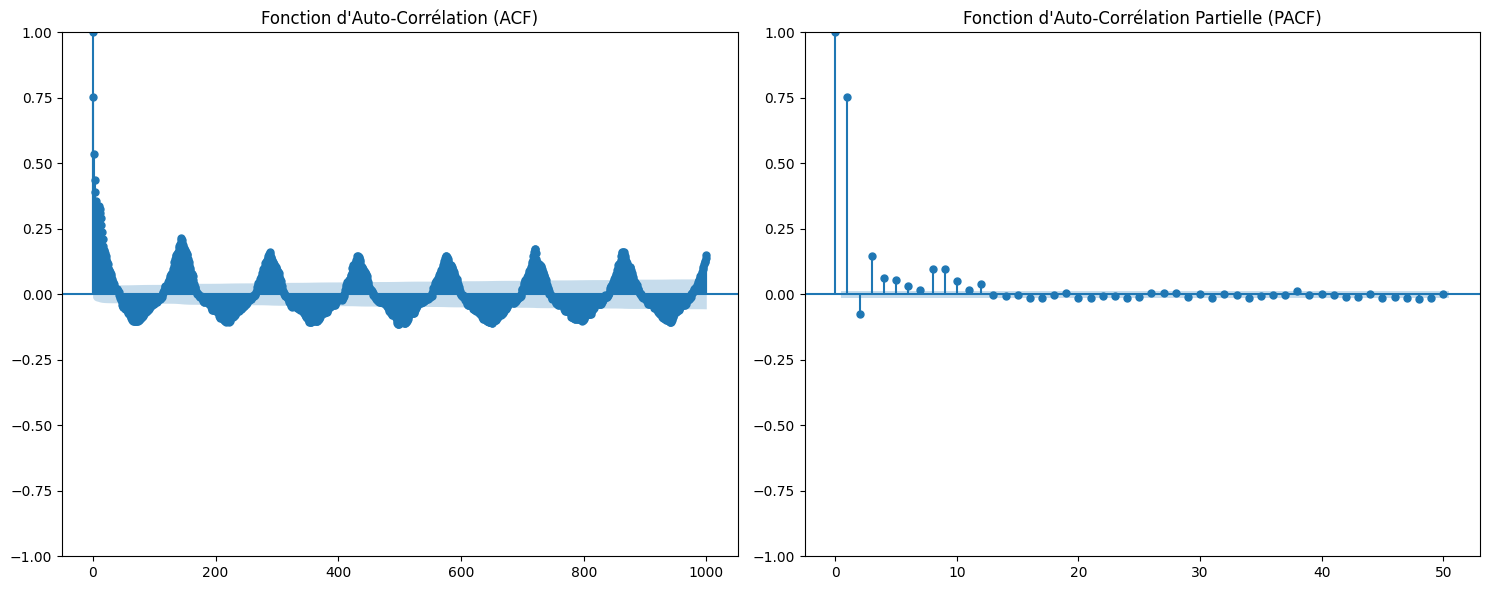

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Générer les graphiques ACF et PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_acf(y, lags=1000, ax=axes[0])  # Graphique ACF
axes[0].set_title("Fonction d'Auto-Corrélation (ACF)")

plot_pacf(y, lags=50, ax=axes[1])  # Graphique PACF
axes[1].set_title("Fonction d'Auto-Corrélation Partielle (PACF)")

plt.tight_layout()
plt.show()

In [6]:
# Taille de la fenêtre d'apprentissage (2 mois)
window_size = (data.index <= "2016-03-11 17:00:00").sum()

In [7]:
elastic_net_params = {
    'alpha': 0.1,
    'l1_ratio': 0.5
}

sarimax_params = {
    'order': (1, 0, 1), 
    'seasonal_order': (1, 0, 1, 14)
}

---
# <b>4. Entraînement et évaluation du modèle</b>

In [8]:
results, metrics, metrics_evolution = src.online_window_fit(
    ElasticNet,
    SARIMAX,
    X,
    y,
    window_size=window_size,
    step_size=144,
    forecast_model_params=elastic_net_params,
    residual_model_params=sarimax_params
)

1 | Apprentissage des données de 2016-01-11 17:00:00 à 2016-03-11 17:00:00 | Prévision de 2016-03-11 17:10:00 à 2016-03-12 17:00:00
2 | Apprentissage des données de 2016-01-12 17:00:00 à 2016-03-12 17:00:00 | Prévision de 2016-03-12 17:10:00 à 2016-03-13 17:00:00
3 | Apprentissage des données de 2016-01-13 17:00:00 à 2016-03-13 17:00:00 | Prévision de 2016-03-13 17:10:00 à 2016-03-14 17:00:00
4 | Apprentissage des données de 2016-01-14 17:00:00 à 2016-03-14 17:00:00 | Prévision de 2016-03-14 17:10:00 à 2016-03-15 17:00:00
5 | Apprentissage des données de 2016-01-15 17:00:00 à 2016-03-15 17:00:00 | Prévision de 2016-03-15 17:10:00 à 2016-03-16 17:00:00
6 | Apprentissage des données de 2016-01-16 17:00:00 à 2016-03-16 17:00:00 | Prévision de 2016-03-16 17:10:00 à 2016-03-17 17:00:00
7 | Apprentissage des données de 2016-01-17 17:00:00 à 2016-03-17 17:00:00 | Prévision de 2016-03-17 17:10:00 à 2016-03-18 17:00:00
8 | Apprentissage des données de 2016-01-18 17:00:00 à 2016-03-18 17:00:00 |

In [9]:
metrics

,MSE,RMSE,MAE,MAPE
0,7887.277951,88.810348,51.007694,0.559167


In [10]:
month_labels = {
    1: 'Janvier',
    2: 'Février',
    3: 'Mars',
    4: 'Avril',
    5: 'Mai'
}

period_begin = results.index.min()
period_end = results.index.max()

# Intervalle de dates pour l'axe temporel des affichages
date_range = pd.date_range(start=period_begin, end=period_end, freq='14D').strftime('%Y-%m-%d').tolist()
date_labels = [f'{pd.to_datetime(d).day} {month_labels[pd.to_datetime(d).month]}' for d in date_range]

In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=results.index, y=results['y_true'], mode='lines', name='Valeur réelle'))
fig.add_trace(go.Scatter(x=results.index, y=results['y_pred'], mode='lines', name='Prédiction', line=dict(color='red')))

fig.update_layout(
    title='Prédictions du modèle Elastic-SARIMAX',
    xaxis_title='Dates',
    xaxis_tickvals=date_range,
    xaxis_ticktext=date_labels,
    yaxis_title='Consommation (en Wh)'
    )

fig.show()

In [12]:
for metric in metrics_evolution:
    fig = px.line(metrics_evolution, x=metrics_evolution.index, y=metric, title=f'Évolution de la {metric}')

    fig.update_layout(
        xaxis_title='Itérations',
        width=1000
    )

    fig.show()

---